# Install Libraries

In [ ]:
!pip install tensorflow pandas numpy sklearn
!pip install pandas scikit-learn
!pip install lime shap
!pip install imbalanced-learn
!pip install dice-ml

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from imblearn.under_sampling import ClusterCentroids, NearMiss, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, NeighbourhoodCleaningRule, OneSidedSelection
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.metrics import AUC, Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, auc

# Read Preprocessed Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path_AU_preprocessed = '/content/drive/MyDrive/CKD/Finalised/data/preprocessed/AU/AU_preprocessed_df.csv'
file_path_JP_preprocessed = '/content/drive/MyDrive/CKD/Finalised/data/preprocessed/JP/JP_preprocessed_df.csv'

# Feature Engineering - AU Dataset

In [5]:
# Compute slope
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

def process_au_dataframe(file_path):
    AU_df = pd.read_csv(file_path)
    AU_df['COLLECTED'] = pd.to_datetime(AU_df['COLLECTED'])
    AU_df = AU_df.reset_index(drop=True)

    # Convert 'COLLECTED' to float for calculation purposes
    AU_df['COLLECTED'] = AU_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID'
    grouped = AU_df.groupby('ID')

    # Compute slopes for each group and directly assign them to the DataFrame
    AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

    # Calculate mean and std for eGFR
    AU_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    AU_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    AU_df.fillna(0, inplace=True)

    return AU_df

In [6]:
# Apply to AU dataset to obtain final features
AU_df = process_au_dataframe(file_path_AU_preprocessed)
AU_df = AU_df.drop_duplicates(subset='ID', keep='last')
AU_df = AU_df.reset_index()
AU_df.drop(columns=['index', 'COLLECTED', 'ID'], inplace=True)
AU_df

<ipython-input-5-bca0dc4c2494>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  AU_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


SEX  AGE  eGFR  Kidney_Failure  eGFR_slope  eGFR_mean   eGFR_std
0        1   46    17               1   -0.045462  18.055556   2.099642
1        1   69    81               0    0.009469  64.375000  13.968715
2        2   83    81               0    0.375050  68.500000  11.445523
3        2   70    91               0    0.033512  84.083333  12.336647
4        1   83    16               0   -0.169529  32.380952   6.566554
...    ...  ...   ...             ...         ...        ...        ...
10059    2   81    41               0    1.649853  40.000000   2.708013
10060    1   69    39               0   -0.415541  55.400000  13.277801
10061    1   72    64               0    3.841912  60.666667   3.511885
10062    1   84    50               0   -2.396167  52.666667   2.516611
10063    1   72    49               0   -3.435050  50.666667   3.785939

[10064 rows x 7 columns]

# Feature Engineering - JP Dataset

In [7]:
# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

# Compute slope
def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def process_dataframe(file_path):
    JP_df = pd.read_csv(file_path)
    JP_df = JP_df.reset_index(drop=True)

    # Apply the function to the 'Time' column to create a new 'Months' column
    JP_df['Months'] = JP_df['Time'].apply(convert_to_months)

    # Assume a starting date for all IDs
    start_date = pd.Timestamp('2020-01-01')

    # Create a 'COLLECTED' column based on the 'Months' column
    JP_df['COLLECTED'] = JP_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

    # Convert 'COLLECTED' to float for calculation purposes
    JP_df['COLLECTED'] = JP_df['COLLECTED'].apply(datetime_to_float)

    # Group the DataFrame by 'ID' and calculate slopes, mean, and std for eGFR
    grouped = JP_df.groupby('ID')
    JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']
    JP_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
    JP_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

    # Fill any NaN values that might have cropped up during calculation
    JP_df.fillna(0, inplace=True)

    return JP_df

In [8]:
# Apply to JP dataset to obtain final features
JP_df = process_dataframe(file_path_JP_preprocessed)
JP_df = JP_df.drop_duplicates(subset='ID', keep='last')
JP_df = JP_df.reset_index()
JP_df.drop(columns=['index', 'COLLECTED', 'ID'], inplace=True)
JP_df

<ipython-input-7-9695f04132f4>:41: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  JP_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']


SEX              Time  AGE       eGFR  Kidney_Failure  Months  \
0      2  eGFR(last visit)   77  22.501266               0      42   
1      1  eGFR(last visit)   63  31.122497               0      42   
2      2  eGFR(last visit)   67  52.723521               0      42   
3      1  eGFR(last visit)   81  28.367088               0      42   
4      1  eGFR(last visit)   75  59.473437               0      42   
..   ...               ...  ...        ...             ...     ...   
592    1  eGFR(last visit)   78  17.544560               0      42   
593    2  eGFR(last visit)   69  55.024770               0      42   
594    1  eGFR(last visit)   84  20.203155               0      42   
595    1  eGFR(last visit)   63  54.572415               0      42   
596    1  eGFR(last visit)   55  36.758771               0      42   

     eGFR_slope  eGFR_mean   eGFR_std  
0     -0.015137  29.643276   7.328739  
1     -0.000594  32.782173   2.383736  
2      0.009158  48.577456   8.327068  
3     -0.023434  45.492439  11.840661  
4      0.000127  58.290224   1.683767  
..          ...        ...        ...  
592   -0.005829  19.248703   3.447072  
593    0.008088  49.596328   5.243989  
594   -0.011671  25.153274   6.111866  
595   -0.001015  58.403641   3.721187  
596   -0.001151  36.370115   2.238376  

[597 rows x 9 columns]

# Training and Evaluation with AU Data

## Cluster-based Undersampling applied to AU Dataset

In [9]:
from imblearn.under_sampling import ClusterCentroids

# Define features and target variable
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X = AU_df[features]
y = AU_df['Kidney_Failure']
print(y.value_counts())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ClusterCentroids based undersampling
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_scaled, y)

print(y_cc.value_counts())

# Re-assign features and target
X = X_cc
y = y_cc

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    9711
1     353
Name: Kidney_Failure, dtype: int64
0    353
1    353
Name: Kidney_Failure, dtype: int64


## Perform Hyperparameter Tuning and Evaluate Decision Tree on AU Dataset

In [11]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define the scoring dictionary
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score),
    'specificity': make_scorer(specificity_score)
}

# Parameter grid for DecisionTreeClassifier
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Seeds to loop over
seed_values = range(10)

# Initialize accumulators for ROC curve data
mean_fpr = np.linspace(0, 1, 100)
seed_results = []

# Loop over seeds
for seed_value in seed_values:
    random.seed(seed_value)
    np.random.seed(seed_value)

    # Initialize a Decision Tree model
    clf = DecisionTreeClassifier(random_state=seed_value)

    # Initialize GridSearch
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
                               scoring=scoring, n_jobs=-1, verbose=1, refit='f1_score')

    # Fit the GridSearch model
    grid_search.fit(X, y)

    # Extract the best estimator
    best_clf = grid_search.best_estimator_

    # Initialize accumulators for metrics, ROC curve data, and confusion matrix components
    fold_metrics = []
    fold_tprs = []
    fold_aucs = []
    cm_components = []

    # Use Stratified KFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train using the best estimator
        best_clf.fit(X_train, y_train)

        # Get predicted probabilities for the positive class
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # Compute confusion matrix and metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Store CM components for each fold
        cm_components.append((tn, fp, fn, tp))

        # Calculate metrics using confusion matrix components
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        roc_auc = roc_auc_score(y_test, y_pred_proba)

        fold_metrics.append({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
                             'F1_Score': f1, 'Specificity': specificity, 'ROC_AUC': roc_auc})

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        fold_tprs.append(np.interp(mean_fpr, fpr, tpr))
        fold_aucs.append(roc_auc)

    # Store the metrics, ROC data, and confusion matrix components
    seed_results.append({
        'seed': seed_value,
        'metrics': fold_metrics,
        'tprs': fold_tprs,
        'aucs': fold_aucs,
        'params': grid_search.best_params_,
        'cm_components': cm_components
    })

# ------------

# Find the best seed based on the highest mean F1 score
mean_f1_scores = [np.mean([fm['F1_Score'] for fm in res['metrics']]) for res in seed_results]
best_seed_idx = np.argmax(mean_f1_scores)
best_seed_data = seed_results[best_seed_idx]

# Calculate the mean and standard deviation for metrics and AUC for the best seed
mean_metrics = {metric: np.mean([m[metric] for m in best_seed_data['metrics']]) for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity']}
std_metrics = {metric: np.std([m[metric] for m in best_seed_data['metrics']]) for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity']}

# Calculate the mean AUCs for the best seed
mean_auc = np.mean(best_seed_data['aucs'])
std_auc = np.std(best_seed_data['aucs'])

# Calculate the mean TPRs for the best seed
mean_tpr = np.mean(best_seed_data['tprs'], axis=0)
mean_tpr[-1] = 1.0 # Ensure it ends at 1.0

# ------------

# Print the best seed's performance metrics
print(f"Best seed: {best_seed_data['seed']}")
print("Best seed's performance metrics:")
for metric, value in mean_metrics.items():
  print(f"{metric}: {value:.4f} (± {std_metrics[metric]:.4f})")
print(f"Mean ROC AUC: {mean_auc:.4f} (± {std_auc:.4f})")
print("Best Hyperparameters:", best_seed_data['params'])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best seed: 5
Best seed's performance metrics:
Accuracy: 0.9066 (± 0.0345)
Precision: 0.9176 (± 0.0469)
Recall: 0.8951 (± 0.0295)
F1_Score: 0.9057 (± 0.0337)
Specificity: 0.9181 (± 0.0497)
Mean ROC AUC: 0.9409 (± 0.0313)
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


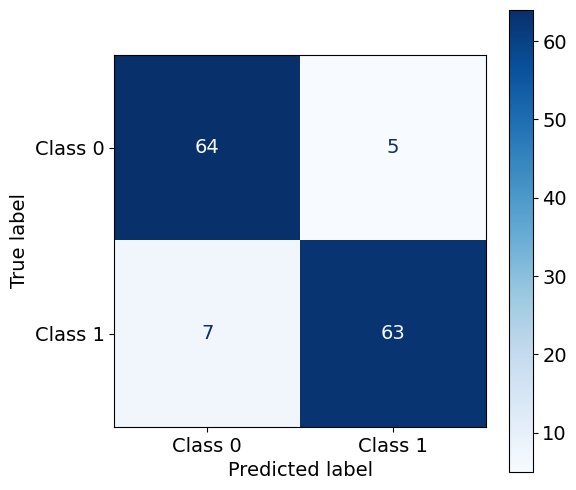

In [12]:
# Average the confusion matrix components for the best seed
avg_cm_components = np.mean(best_seed_data['cm_components'], axis=0).astype(int)
avg_cm = np.array([[avg_cm_components[0], avg_cm_components[1]], [avg_cm_components[2], avg_cm_components[3]]])

# Display the averaged confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=['Class 0', 'Class 1'])
plt.rcParams.update({'font.size': 14})

# Set plot dimensions and font size
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(cmap='Blues', ax=ax)
# plt.title('Averaged Confusion Matrix for Best Hyperparameters', fontsize=12)  # Set title font size
plt.title('')
plt.xticks() # fontsize=12
plt.yticks()

plt.show()

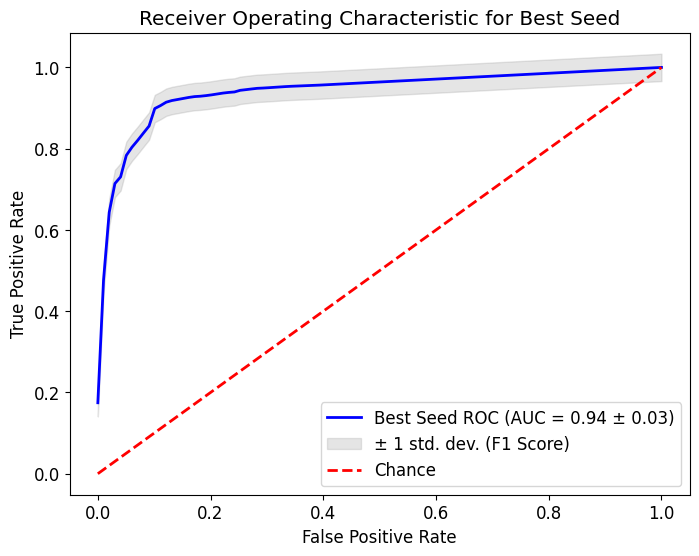

In [13]:
# Plotting the ROC curve for the best seed
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Best Seed ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
plt.fill_between(mean_fpr, mean_tpr - std_metrics['F1_Score'], mean_tpr + std_metrics['F1_Score'], color='grey', alpha=0.2, label=r'± 1 std. dev. (F1 Score)')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best Seed')
plt.legend(loc='lower right')
plt.show()

In [14]:
import pickle

data_to_export = {
    'mean_fpr': mean_fpr,
    'mean_tpr': mean_tpr,
    'mean_auc': mean_auc,
    'std_auc': std_auc,
    'model_name': 'Decision Tree'  # Change this for each model
}

# Exporting to a pickle file
with open(f'{data_to_export["model_name"]}_roc_data.pkl', 'wb') as file:
    pickle.dump(data_to_export, file)


## Retrain Decision Tree on the Entire AU Dataset

In [15]:
# Extract the best hyperparameters for the model
best_seed = best_seed_data['seed']
best_params = best_seed_data['params']
print("Best Hyperparameters:", best_params)

# Reinitialize the model with the best parameters
best_model = DecisionTreeClassifier(**best_params, random_state=best_seed)

# Retrain the model on the entire dataset
best_model.fit(X, y)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, random_state=5)

## Feature Importance

In [16]:
# Get feature importances
importances = best_model.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR (0.735274)
2.	feature eGFR_slope (0.171761)
3.	feature eGFR_mean (0.055819)
4.	feature AGE (0.034968)
5.	feature SEX (0.002179)


## Visualise Tree

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is the trained decision tree
plt.figure(figsize=(400, 30))
plot_tree(best_model, filled=True, feature_names=features, class_names=str(best_model.classes_), rounded=True, fontsize=10)
plt.show()

In [18]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

tree_to_ifelse(best_model, features)

if eGFR <= -0.86:
  if eGFR <= -1.52:
    if eGFR_slope <= -1.38:
      return class = 0
    else: # if eGFR_slope > -1.38
      if eGFR_slope <= -0.17:
        if SEX <= 0.01:
          return class = 1
        else: # if SEX > 0.01
          if eGFR_mean <= -1.62:
            return class = 1
          else: # if eGFR_mean > -1.62
            return class = 0
      else: # if eGFR_slope > -0.17
        return class = 1
  else: # if eGFR > -1.52
    if eGFR_mean <= -0.79:
      if eGFR_slope <= -0.15:
        if AGE <= -0.36:
          if eGFR_mean <= -1.44:
            if AGE <= -1.22:
              return class = 1
            else: # if AGE > -1.22
              return class = 0
          else: # if eGFR_mean > -1.44
            return class = 0
        else: # if AGE > -0.36
          if AGE <= 1.14:
            if eGFR_slope <= -0.92:
              return class = 0
            else: # if eGFR_slope > -0.92
              if eGFR_slope <= -0.18:
                return class = 0
   


# Transfer learning with JP Data (without fine-tuning on 15% subset)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone

# Using the already trained best_model
clf = best_model

# Dataset features and target
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X_test = JP_df[features]
y_test = JP_df['Kidney_Failure']

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
threshold = 0.5

# Evaluate on the held-out test set
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics manually using confusion matrix components
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model performance on the test set:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Specificity: {specificity}")

Model performance on the test set:
Accuracy: 0.7520938023450586
Precision: 0.5972222222222222
Recall (Sensitivity): 0.2654320987654321
F1 Score: 0.36752136752136755
ROC AUC: 0.7508230452674898
Specificity: 0.9333333333333333


In [ ]:
# Get feature importances
importances = clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR (0.735274)
2.	feature eGFR_slope (0.171761)
3.	feature eGFR_mean (0.055819)
4.	feature AGE (0.034968)
5.	feature SEX (0.002179)


# Transfer Learning with JP Dataset (fine-tuning on 15% subset)

Model performance on the test set:
Accuracy: 0.860236220472441
Precision: 0.6914285714285714
Recall (Sensitivity): 0.8768115942028986
F1 Score: 0.7731629392971247
ROC AUC: 0.8821876224050137
Specificity: 0.8540540540540541


<ipython-input-19-0f2bb7b811f2>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Class 0', 'Class 1'])
<ipython-input-19-0f2bb7b811f2>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Class 0', 'Class 1'])


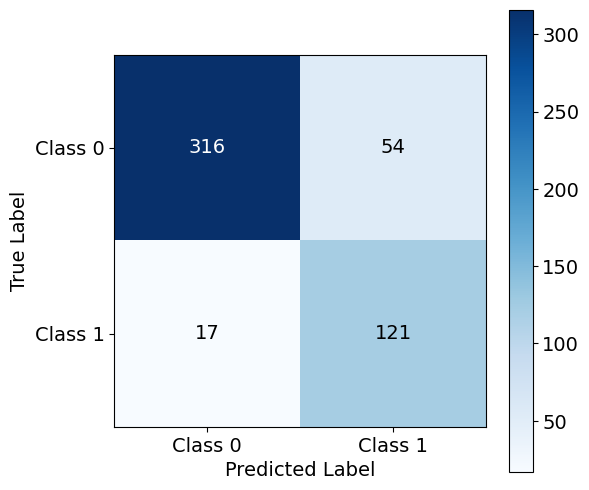

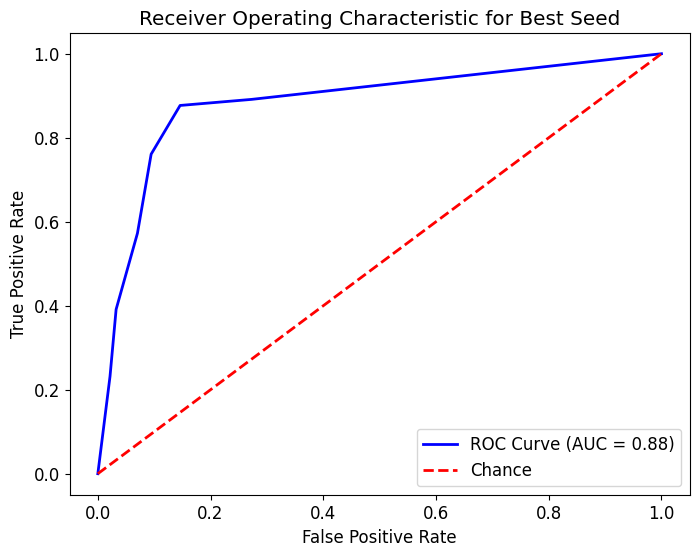

In [19]:
import numpy as np
import pandas as pd
import random
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

threshold = 0.5

# Dataset features and target
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X = JP_df[features]
y = JP_df['Kidney_Failure']

X_scaled = scaler.fit_transform(X)

# List to store results
results_list = []

seed_value = 48
random.seed(seed_value)
np.random.seed(seed_value)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.85, random_state=seed_value, stratify=y)

clf = best_model
clf.fit(X_train, y_train)

# Evaluate on the held-out test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)  # Applying threshold

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate metrics manually using confusion matrix components
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# print(tn, fp, fn, tp, accuracy, precision, recall, f1, specificity, roc_auc)

print(f"Model performance on the test set:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Specificity: {specificity}")

# Plotting the confusion matrix for the best seed
cm = np.array([[tn, fp], [fn, tp]]).astype(int)  # Assuming tn, fp, fn, tp are correctly defined
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
plt.title('')
ax.set_xticklabels(['', 'Class 0', 'Class 1'])
ax.set_yticklabels(['', 'Class 0', 'Class 1'])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
for i in range(2):
    for j in range(2):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

# ------------------

# Plotting the ROC curve for the best seed
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Best Seed')
plt.legend(loc="lower right")
plt.show()

In [20]:
import pickle

data_to_export = {
    'best_fpr': fpr,
    'best_tpr': tpr,
    'best_roc_auc': roc_auc,
    'model_name': 'Decision Tree JP'  # Change this for each model
}

# Exporting to a pickle file
with open(f'{data_to_export["model_name"]}_roc_data.pkl', 'wb') as file:
    pickle.dump(data_to_export, file)

## Feature Importances

In [21]:
# Get feature importances
importances = clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR (0.455093)
2.	feature eGFR_slope (0.336166)
3.	feature eGFR_mean (0.130841)
4.	feature AGE (0.077901)
5.	feature SEX (0.000000)


## Visualise Tree

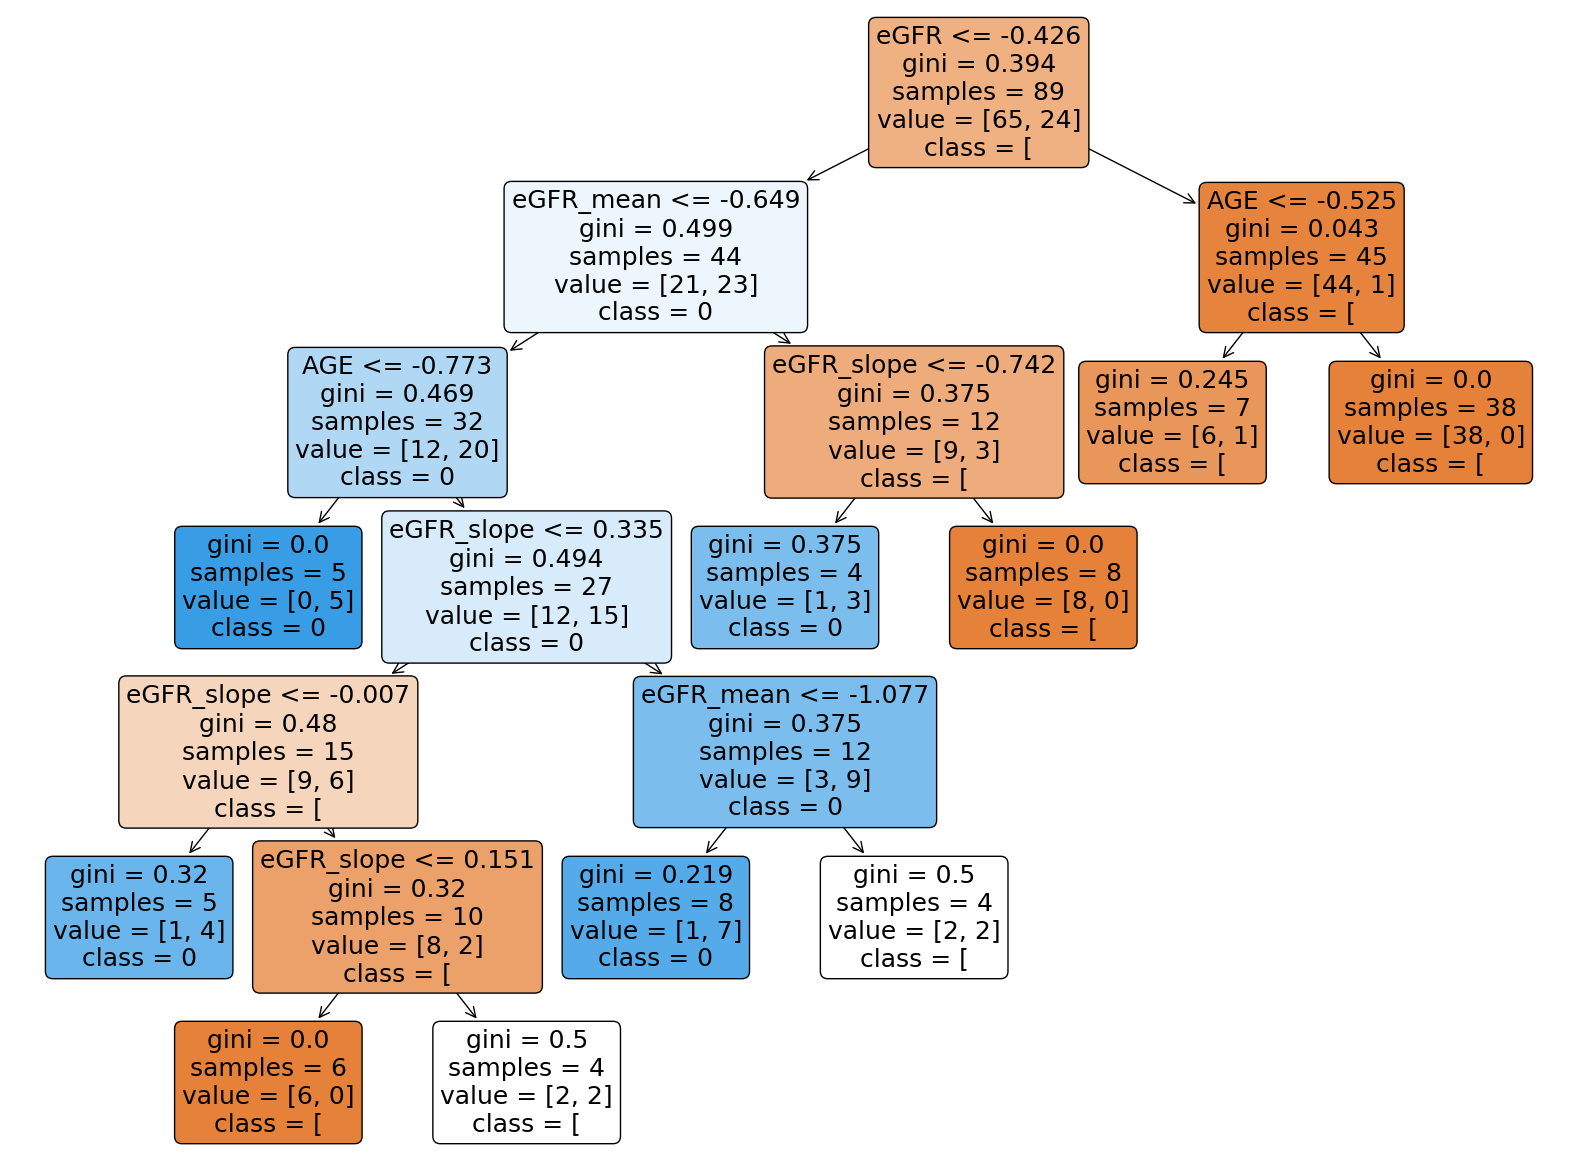

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is the trained decision tree
plt.figure(figsize=(20, 15))
plot_tree(clf, filled=True, feature_names=features, class_names=str(clf.classes_), rounded=True, fontsize=18)
plt.show()

In [ ]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

# Using the function
tree_to_ifelse(clf, features)

if eGFR <= -0.43:
  if eGFR_mean <= -0.65:
    if AGE <= -0.77:
      return class = 1
    else: # if AGE > -0.77
      if eGFR_slope <= 0.34:
        if eGFR_slope <= -0.01:
          return class = 1
        else: # if eGFR_slope > -0.01
          if eGFR_slope <= 0.15:
            return class = 0
          else: # if eGFR_slope > 0.15
            return class = 0
      else: # if eGFR_slope > 0.34
        if eGFR_mean <= -1.08:
          return class = 1
        else: # if eGFR_mean > -1.08
          return class = 0
  else: # if eGFR_mean > -0.65
    if eGFR_slope <= -0.74:
      return class = 1
    else: # if eGFR_slope > -0.74
      return class = 0
else: # if eGFR > -0.43
  if AGE <= -0.52:
    return class = 0
  else: # if AGE > -0.52
    return class = 0


## DICE

In [ ]:
threshold = 0.5

# Dataset features and target
features = ['SEX', 'AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean']
X = JP_df[features]
y = JP_df['Kidney_Failure']

X_scaled = scaler.fit_transform(X)

# List to store results
results_list = []

seed_value = 48
random.seed(seed_value)
np.random.seed(seed_value)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.85, random_state=seed_value, stratify=y)

import dice_ml
from dice_ml.utils import helpers  # helper functions

# Step 1: Combine scaled test features and labels into one dataframe
X_test_df = pd.DataFrame(X_test, columns=features)
y_test_series = pd.Series(y_test, name='Kidney_Failure')
test_data = pd.concat([X_test_df, y_test_series], axis=1)

# Reset the indices
X_test_df.reset_index(drop=True, inplace=True)
y_test_series.reset_index(drop=True, inplace=True)

# Combine X and y into one DataFrame
test_data = pd.concat([X_test_df, y_test_series], axis=1)

In [ ]:
# Step 2: Create a DiCE Data object
d = dice_ml.Data(dataframe=test_data,
                 continuous_features=['AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean'],
                 outcome_name='Kidney_Failure')

# Step 3: Create a Model Wrapper if necessary
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, input_array):
        return self.model.predict_proba(input_array)

wrapped_model = ModelWrapper(clf)

# Step 4: Create a DiCE model object
m = dice_ml.Model(model=wrapped_model, backend='sklearn')

# Step 5: Create a DiCE explainer object
exp = dice_ml.Dice(d, m)

# Step 6: Select an instance to explain
# Note that DiCE requires the instance in the form of a dataframe
instance_index_to_explain = 67  # Change this to the index you want to explain
query_instance = X_test_df.iloc[[instance_index_to_explain]].reset_index(drop=True)

# Step 7: Generate counterfactuals
cf = exp.generate_counterfactuals(query_instance, total_CFs=2, desired_class='opposite')

# Step 8: Visualize the counterfactuals
cf.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Deci

Query instance (original outcome : 1)


SEX       AGE     eGFR  eGFR_slope  eGFR_mean  Kidney_Failure
0 -0.610257 -3.750178 -1.05305    0.269092  -1.347137               1


Diverse Counterfactual set (new outcome: 0)


SEX         AGE         eGFR eGFR_slope     eGFR_mean Kidney_Failure
0   -           -  -0.04094671          -  -0.252050851            0.0
1   -  0.33955538            -          -             -            0.0

In [ ]:
# Step 2: Create a DiCE Data object
d = dice_ml.Data(dataframe=test_data,
                 continuous_features=['AGE', 'eGFR', 'eGFR_slope', 'eGFR_mean'],
                 outcome_name='Kidney_Failure')

# Step 3: Create a Model Wrapper if necessary
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, input_array):
        return self.model.predict_proba(input_array)

wrapped_model = ModelWrapper(clf)

# Step 4: Create a DiCE model object
m = dice_ml.Model(model=wrapped_model, backend='sklearn')

# Step 5: Create a DiCE explainer object
exp = dice_ml.Dice(d, m)

# Step 6: Select an instance to explain
instance_index_to_explain = 67  # Change this to the index you want to explain
query_instance = X_test_df.iloc[[instance_index_to_explain]].reset_index(drop=True)

# # Step 7: Generate counterfactuals
# cf = exp.generate_counterfactuals(query_instance, total_CFs=2, desired_class='opposite')

# # Step 8: Visualize the counterfactuals
# cf.visualize_as_dataframe(show_only_changes=True)

# Step 7: Generate counterfactuals with specific constraints
# Specify the range for eGFR_mean based on manual exploration
permitted_range = {'eGFR_mean': [-0.6565656565656566, -0.5555555555555554]}

# Generate counterfactuals focusing on eGFR_mean
cf = exp.generate_counterfactuals(query_instance,
                                  total_CFs=3,  # Number of counterfactuals to generate
                                  desired_class="opposite",  # Change to the opposite class
                                  features_to_vary=['eGFR_mean'],  # Only vary eGFR_mean
                                  permitted_range=permitted_range)

# Step 8: Visualize the counterfactuals
cf.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Deci

Query instance (original outcome : 1)


SEX       AGE     eGFR  eGFR_slope  eGFR_mean  Kidney_Failure
0 -0.610257 -3.750178 -1.05305    0.269092  -1.347137               1


Diverse Counterfactual set (new outcome: 0)


SEX AGE eGFR eGFR_slope     eGFR_mean Kidney_Failure
0   -   -    -          -  -0.616677635            0.0
1   -   -    -          -  -0.593937921            0.0
2   -   -    -          -  -0.614921407            0.0

In [ ]:
# Converting scaled results back to original eGFR_mean values
# -1.347137: 15.395879705736068
# -0.616677635 : 25.483217979485385
# -0.593937921 : 25.797243917624073
# -0.614921407 : 25.507470753521392

In [ ]:
# original_instance = X_test[67]
# original_prediction = clf.predict_proba(original_instance.reshape(1, -1))[0, 1]
# original_prediction

# original_instance = X_test[67]
# original_prediction = clf.predict_proba(original_instance.reshape(1, -1))[0, 1]

# # Now, create a function to alter a feature and observe the change in prediction
# def alter_feature_and_predict(instance, feature_index, new_value):
#     modified_instance = instance.copy()
#     modified_instance[feature_index] = new_value
#     new_prediction = clf.predict_proba(modified_instance.reshape(1, -1))[0, 1]
#     return new_prediction

# feature_index = 4  # Index of eGFR_slope in features list

# # Define a range of new values to try for eGFR_slope
# new_values = np.linspace(-5, 5, 100)  # Define appropriate min_value, max_value, num_steps

# # Observe how the predictions change with each new value
# for new_value in new_values:
#     new_prediction = alter_feature_and_predict(original_instance, feature_index, new_value)
#     print(f"eGFR_mean: {new_value}, Predicted Probability of Kidney Failure: {new_prediction}")


eGFR_mean: -5.0, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.898989898989899, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.797979797979798, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.696969696969697, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.595959595959596, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.494949494949495, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.393939393939394, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.292929292929293, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.191919191919192, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -4.090909090909091, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -3.9898989898989896, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -3.888888888888889, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -3.787878787878788, Predicted Probability of Kidney Failure: 1.0
eGFR_mean: -3.68686868686

## LIME

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import random

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Set the desired plot size for matplotlib
plt.rcParams["figure.figsize"] = (25, 20)

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train,
                                 feature_names=features,
                                 class_names=['No Kidney Failure', 'Kidney Failure'],
                                 discretize_continuous=True)

# Choose an instance to explain
i = 67

# Generate the explanation for the chosen instance
exp = explainer.explain_instance(X_test[i], clf.predict_proba, num_features=len(features))

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)

# Print the true value for the instance
true_value = y_test.iloc[i]
print(f"True Value for instance {i}: {true_value}")

exp.save_to_file('lime_explanation.html')


True Value for instance 67: 1


In [29]:
scaled_threshold_egfr_mean = -0.91

# Find the scale (standard deviation) for 'eGFR_mean' and the mean
scale_egfr_mean = scaler.scale_[features.index('eGFR_mean')]
mean_egfr_mean = scaler.mean_[features.index('eGFR_mean')]

# Apply inverse transform manually
original_threshold_egfr_mean = (scaled_threshold_egfr_mean * scale_egfr_mean) + mean_egfr_mean

print(original_threshold_egfr_mean)

21.432558817888946


In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create an explainer object
explainer = LimeTabularExplainer(X_train,
                                 feature_names=features,
                                 class_names=['No Kidney Failure', 'Kidney Failure'],
                                 discretize_continuous=True)

# Get an instance to interpret
i = random.randint(0, len(X_test)-1)
exp = explainer.explain_instance(X_test[i], clf.predict_proba)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

true_value = y_test.iloc[i]
print(f"True Value for instance {i}: {true_value}")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # Set the desired width and height

True Value for instance 364: 0


## SHAP

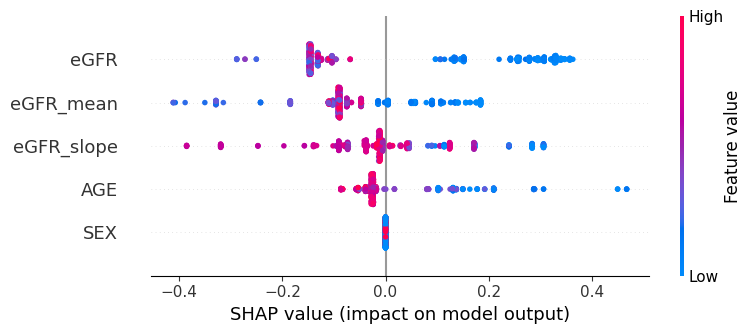

In [23]:
import shap

# Initialize SHAP's tree explainer with the model
explainer = shap.TreeExplainer(clf)

# # Compute SHAP values for a sample from the test set
shap_values = explainer.shap_values(X_test)
shap_values_positive_class = shap_values[:, :, 1]  # This selects the SHAP values for the positive class

# Summary plot for the positive class
shap.summary_plot(shap_values_positive_class, X_test, feature_names=features)

# Comparison with Random Forest and RNN

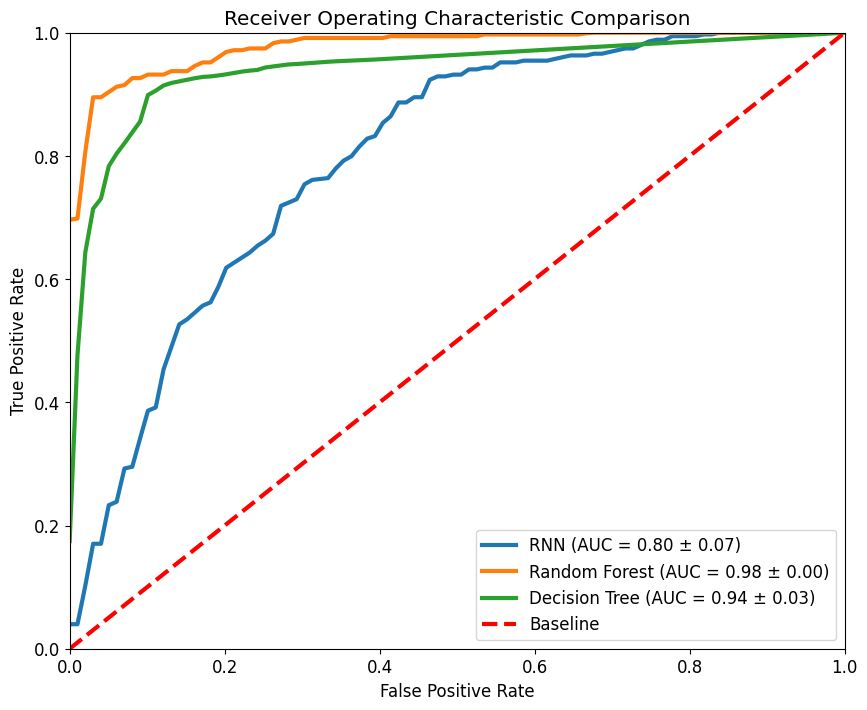

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12})

model_names = ['RNN', 'Random Forest', 'Decision Tree']
plt.figure(figsize=(10, 8))

# Plotting ROC curves for each model
for model_name in model_names:
    with open(f'{model_name}_roc_data.pkl', 'rb') as file:
        data = pickle.load(file)
        plt.plot(data['mean_fpr'], data['mean_tpr'], lw=3, label=f'{model_name} (AUC = {data["mean_auc"]:.2f} ± {data["std_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='red', label='Baseline')

plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc='lower right')
plt.show()

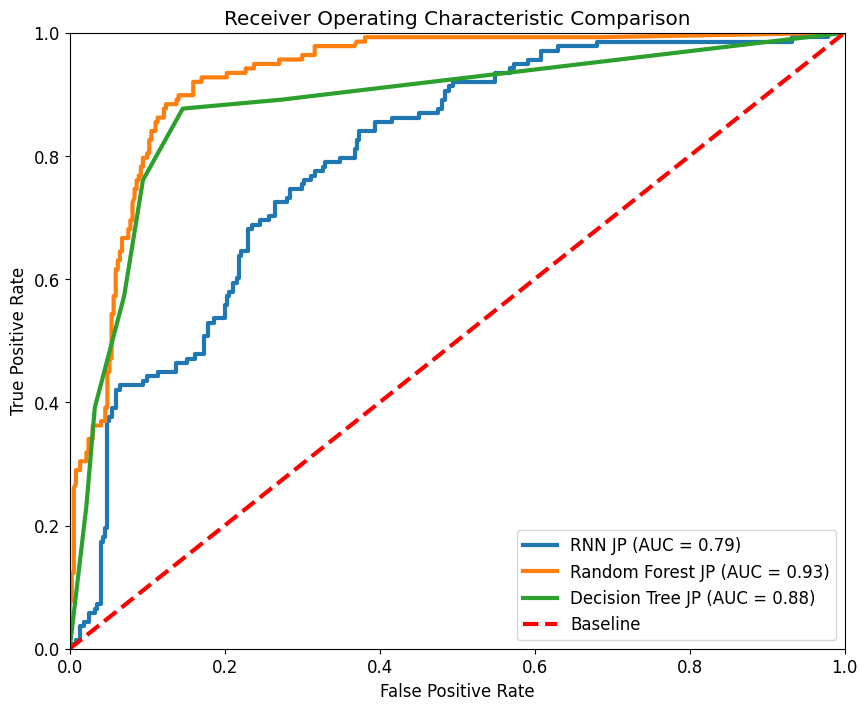

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

model_names = ['RNN JP', 'Random Forest JP', 'Decision Tree JP']
plt.figure(figsize=(10, 8))

# Plotting ROC curves for each model
for model_name in model_names:
    with open(f'{model_name}_roc_data.pkl', 'rb') as file:
        data = pickle.load(file)
        plt.plot(data['best_fpr'], data['best_tpr'], lw=3,
                 label=f'{model_name} (AUC = {data["best_roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='red', label='Baseline')

plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc='lower right')
plt.show()